In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import keras as k
import sklearn
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Reshape, merge
from keras import backend

from keras.models import Sequential
import numba
from numba import jit, cuda
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot



In [3]:
#Load dataset
df = pd.read_csv("UserRatings1.csv")

In [4]:
df.head()
print(k.__version__)


2.2.4


In [5]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

1.12.0


In [6]:
df = df.values

In [7]:
#Prepare data in JokeId, User, Rating format
@jit
def prepare_data(matrix_data):
    m = matrix_data.shape[0]  # Get number of Jokes
    n = matrix_data.shape[1]  # Get number of Users
    jokeids = np.reshape(matrix_data[:,0],[m,1])  # Get joke id in column format
    ones = np.ones((m,1))    #Initialize Ones ( Will be used later)
    data = np.ones((1,3))  # Initialize a temporary matrix
    for i in range(1,n):  # Loop through users
        user = i * ones  # Get user column
        ratings = np.reshape(matrix_data[:,i] , [m,1])  #Get ratings for the user
        temp = np.concatenate((user, jokeids,ratings), axis =1)   # Concatenate User, Jokeid and Ratings
        data = np.concatenate((data,temp))  # Append to data matrix
    data = np.delete(data,0,0)   # Remove first row of ones
    return data
    
        
    
    

In [8]:
data = prepare_data(df)

In [9]:
temp = np.copy(data)

In [10]:
temp = temp[~np.isnan(temp).any(axis=1)]  # Clean up data by removing rows with nan values

In [11]:
np.random.shuffle(temp)    # Shuffle data


In [92]:
#split into train test data
X = temp[:,0:2]   #Get user and joke id
Y = temp[:,2]   # Get Ratings
m1 = Y.shape[0]
Y = np.reshape(Y,[m1,1])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True)    #Split Data
Users = X_train[:,0]
Jokes = X_train[:,1]


In [121]:
#Define Keras Model
def build_model(n_users,k_factors,m_items):
    Joke_input = keras.layers.Input(shape=[1],name='Item')
    Joke_embedding = keras.layers.Embedding(m_items + 1, k_factors, name='Joke-Embedding')(Joke_input)
    Joke_vec = keras.layers.Flatten(name='FlattenJokes')(Joke_embedding)
    
    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, k_factors,name='User-Embedding')(user_input))
   
    prod = keras.layers.Dot(axes=1)([Joke_vec,user_vec])
    model = keras.Model([user_input, Joke_input], prod)
    adam = k.optimizers.adamax(lr=0.01)
    model.compile(adam, 'mean_squared_error', metrics=['accuracy'])
    model.summary()
    
   
    return model

In [124]:
m = Users.shape[0]
Users = np.reshape(Users, [m,1])
Jokes = np.reshape(Jokes,[m,1])
n_users = (np.unique(Users)).shape[0]
print(n_users)
n_jokes = (np.unique(Jokes)).shape[0]
print(n_jokes)

model = build_model(n_users,5,n_jokes)



36710
100
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Joke-Embedding (Embedding)      (None, 1, 5)         505         Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         183555      User[0][0]                       
__________________________________________________________________________________________________


In [ ]:

history = model.fit([Users, Jokes], Y_train, batch_size= 7000, validation_split=0.1,epochs=40)


Train on 2168704 samples, validate on 240968 samples
Epoch 1/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.9883 - acc: 0.0011 - val_loss: 17.1999 - val_acc: 0.0010
Epoch 2/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.9382 - acc: 0.0011 - val_loss: 17.1954 - val_acc: 9.9598e-04
Epoch 3/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.8977 - acc: 0.0011 - val_loss: 17.1886 - val_acc: 9.8353e-04
Epoch 4/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.8651 - acc: 0.0011 - val_loss: 17.1853 - val_acc: 0.0010
Epoch 5/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.8380 - acc: 0.0011 - val_loss: 17.1801 - val_acc: 0.0010
Epoch 6/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.8156 - acc: 0.0011 - val_loss: 17.1785 - val_acc: 0.0010
Epoch 7/40
2168704/2168704 [==============================] - 2s 1us/step - loss: 14.79

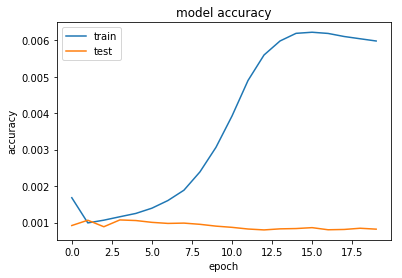

In [117]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


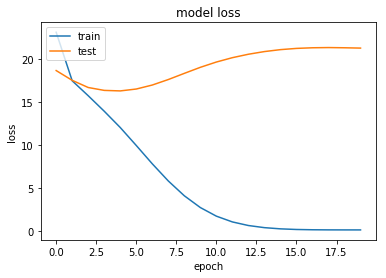

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [120]:
model.save('Model_Joke.h5')